Importowanie bibliotek

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import random
from torch.optim import Adam

Ustawienia początkowe

In [2]:
SEED = 155
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Pobranie danych

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

Podział danych na zbiór treningowy, walidaycjny i testowy.  
Ustawienie batch_size = 128

In [ ]:
val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128 
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

(55000, 5000, 10000)

Sprawdzenie wielkości pojedyńczej próbki 

In [5]:
sample, label = train_loader.dataset[0]
sample.shape


torch.Size([1, 28, 28])

Definiuje zwykły prosty model składający się z dwóch warstw liniowych.  
Do warstwy liniowej trzeba dostarczyć jednowymiarowy wektor, a jego rozmiar przy rozmiarze próbki [28,28] będzie 28*28 = 784.  
Wyjście jeest równe 10 ponieważ jest 10 cyfr.   

Ciekawe jest to, że w PyTorch nie definiujemy np. softmax bezpośrednio w modelu.  
Jest on później używany w nn.CrossEntropyLoss(). 

In [6]:
class BaseLine(nn.Module):
    def __init__(self):
        super(BaseLine, self).__init__()
        self.fc1 = nn.Linear(28*28, 20)
        self.relu = nn.ReLU()                      
        self.fc2 = nn.Linear(20, 10) 

    def forward(self, x):
        x = x.reshape(x.shape[0],28*28)
        x = self.fc1(x)    
        x = self.relu(x)   
        x = self.fc2(x)    
        return x

Definiuje drugi model tym razem konwolucyjnej sieci neuronowej.  
Składa się z dwóch warstw konwolucyjnych, operacji maxpoolingu oraz dwóch warstw liniowych.    
Jest również dropout, który ogranicza overfitting.  

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(64 * 7 * 7, 128)
        self.fc2  = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Definiuje funkcję, która dla zadanego modelu i danych tworzy macierz pomyłek oraz zwraca statystyki klasyfikacji

In [8]:
def results(model,test_loader):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to('cpu', non_blocking=True)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    test_acc = (y_pred == y_true).mean()
    print(f"Test accuracy: {test_acc:.4f}")


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix (MNIST)")
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, tick_marks)
    plt.yticks(tick_marks, tick_marks)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Prawdziwa klasa')
    plt.xlabel('Predykcja')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true, y_pred, digits=4))

Definiuję funkcję, która dla zadanych parametrów trenuje model.  

In [9]:
def run_epoch(loader, train: bool, model, optimizer, criterion):
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to('cpu', non_blocking=True), yb.to('cpu', non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

Definiowanie obiektów, liczby epok i prędkości uczenia się.  

In [11]:
EPOCHS = 20
lr = 1e-3

criterion = nn.CrossEntropyLoss()
model_simple_cnn = SimpleCNN()
model_baseline = BaseLine()
optimizer_baseline = Adam(model_baseline.parameters(), lr=lr)
optimizer_simple_cnn = Adam(model_simple_cnn.parameters(), lr=lr)

Trenowanie baseline i zapisywanie metryk do history_baseline

In [13]:
history_baseline = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True, model_baseline, optimizer_baseline, criterion)
    va_loss, va_acc = run_epoch(val_loader, False, model_baseline, optimizer_baseline, criterion)
    history_baseline["train_loss"].append(tr_loss); history_baseline["train_acc"].append(tr_acc)
    history_baseline["val_loss"].append(va_loss);   history_baseline["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
time_baseline = time.time()-start
print(f"Czas treningu: {time_baseline}s")


e:\Laby\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/20 | train loss 0.4810 acc 0.8612 | val loss 0.2922 acc 0.9170
Ep 02/20 | train loss 0.2615 acc 0.9245 | val loss 0.2446 acc 0.9294
Ep 03/20 | train loss 0.2230 acc 0.9347 | val loss 0.2200 acc 0.9332
Ep 04/20 | train loss 0.1981 acc 0.9420 | val loss 0.2031 acc 0.9408
Ep 05/20 | train loss 0.1793 acc 0.9485 | val loss 0.1911 acc 0.9436
Ep 06/20 | train loss 0.1668 acc 0.9515 | val loss 0.1816 acc 0.9464
Ep 07/20 | train loss 0.1556 acc 0.9543 | val loss 0.1677 acc 0.9500
Ep 08/20 | train loss 0.1460 acc 0.9568 | val loss 0.1719 acc 0.9502
Ep 09/20 | train loss 0.1391 acc 0.9584 | val loss 0.1680 acc 0.9506
Ep 10/20 | train loss 0.1312 acc 0.9611 | val loss 0.1668 acc 0.9506
Ep 11/20 | train loss 0.1276 acc 0.9624 | val loss 0.1576 acc 0.9560
Ep 12/20 | train loss 0.1221 acc 0.9641 | val loss 0.1635 acc 0.9538
Ep 13/20 | train loss 0.1170 acc 0.9654 | val loss 0.1606 acc 0.9558
Ep 14/20 | train loss 0.1131 acc 0.9669 | val loss 0.1633 acc 0.9528
Ep 15/20 | train loss 0.1094 acc 0

Trenowanie baseline i zapisywanie metryk do history_simple_cnn

In [14]:
history_simple_cnn = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
start = time.time()
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True, model_simple_cnn, optimizer_simple_cnn, criterion)
    va_loss, va_acc = run_epoch(val_loader, False, model_simple_cnn, optimizer_simple_cnn, criterion)
    history_simple_cnn["train_loss"].append(tr_loss); history_simple_cnn["train_acc"].append(tr_acc)
    history_simple_cnn["val_loss"].append(va_loss);   history_simple_cnn["val_acc"].append(va_acc)
    print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
time_simple_cnn = time.time()-start
print(f"Czas treningu: {time_baseline}s")

Ep 01/20 | train loss 0.2141 acc 0.9337 | val loss 0.0627 acc 0.9814
Ep 02/20 | train loss 0.0702 acc 0.9786 | val loss 0.0402 acc 0.9866
Ep 03/20 | train loss 0.0502 acc 0.9844 | val loss 0.0369 acc 0.9876
Ep 04/20 | train loss 0.0433 acc 0.9865 | val loss 0.0357 acc 0.9876
Ep 05/20 | train loss 0.0357 acc 0.9883 | val loss 0.0297 acc 0.9892
Ep 06/20 | train loss 0.0296 acc 0.9910 | val loss 0.0299 acc 0.9892
Ep 07/20 | train loss 0.0271 acc 0.9911 | val loss 0.0336 acc 0.9906
Ep 08/20 | train loss 0.0251 acc 0.9913 | val loss 0.0261 acc 0.9922
Ep 09/20 | train loss 0.0228 acc 0.9925 | val loss 0.0297 acc 0.9910
Ep 10/20 | train loss 0.0195 acc 0.9939 | val loss 0.0352 acc 0.9908
Ep 11/20 | train loss 0.0191 acc 0.9934 | val loss 0.0281 acc 0.9918
Ep 12/20 | train loss 0.0166 acc 0.9948 | val loss 0.0328 acc 0.9912
Ep 13/20 | train loss 0.0157 acc 0.9946 | val loss 0.0260 acc 0.9918
Ep 14/20 | train loss 0.0148 acc 0.9946 | val loss 0.0255 acc 0.9932
Ep 15/20 | train loss 0.0142 acc 0

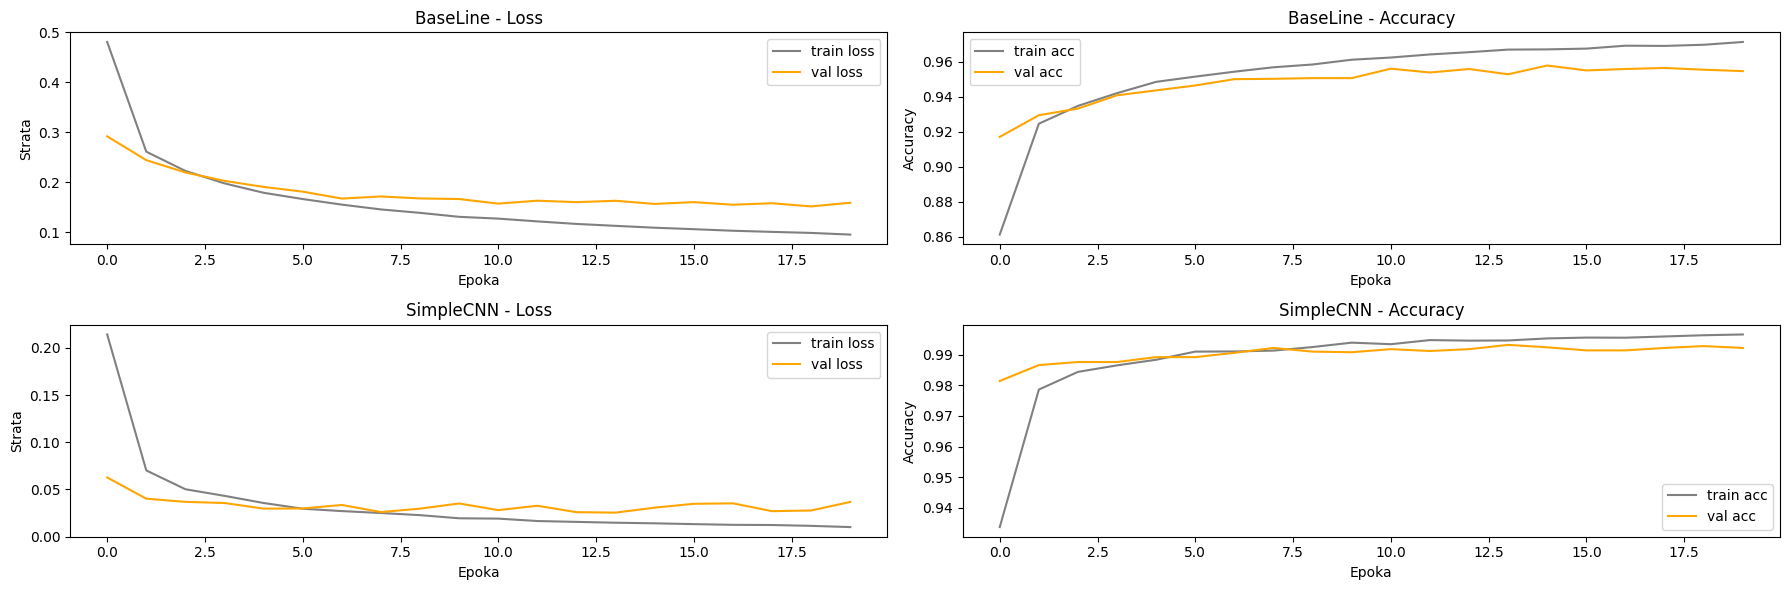

In [21]:

fig, ax = plt.subplots(2, 2, figsize=(18, 6))

ax[0][0].plot(history_baseline["train_loss"],color='gray', label="train loss")
ax[0][0].plot(history_baseline["val_loss"],color='orange' ,label="val loss")
ax[0][0].set_xlabel("Epoka")
ax[0][0].set_ylabel("Strata")
ax[0][0].set_title("BaseLine - Loss")
ax[0][0].legend()

ax[0][1].plot(history_baseline["train_acc"],color='gray', label="train acc")
ax[0][1].plot(history_baseline["val_acc"], color='orange',label="val acc")
ax[0][1].set_xlabel("Epoka")
ax[0][1].set_ylabel("Accuracy")
ax[0][1].set_title("BaseLine - Accuracy")
ax[0][1].legend()

ax[1][0].plot(history_simple_cnn["train_loss"],color='gray', label="train loss")
ax[1][0].plot(history_simple_cnn["val_loss"],color='orange' ,label="val loss")
ax[1][0].set_xlabel("Epoka")
ax[1][0].set_ylabel("Strata")
ax[1][0].set_title("SimpleCNN - Loss")
ax[1][0].legend()

ax[1][1].plot(history_simple_cnn["train_acc"],color='gray', label="train acc")
ax[1][1].plot(history_simple_cnn["val_acc"], color='orange',label="val acc")
ax[1][1].set_xlabel("Epoka")
ax[1][1].set_ylabel("Accuracy")
ax[1][1].set_title("SimpleCNN - Accuracy")
ax[1][1].legend()

plt.tight_layout()
plt.show()

Model Baseline  

Z każdą kolejną epoką występuje wzrost dokładności dla zbioru treningowego.  
Dla zbioru walidacyjnego od 7 epoki dokładność znacząco nie zmienia się. Natomiast od epoki 15 wydaje się, że zaczyna nieznacznie maleć.  
Podobna sytuacja jest dla wykresu funkcji straty. Od 7 epoki wartość funkcji straty praktycznie się nie zmienia, a ta sama wartość dla zbioru  
treningowego się stale zmniejsza.  

Takie wyniki sa skutkiem przeuczenia modelu. od 7 epoki model z każdą kolejną epoką dopasowuje się do danych treningowych, co nie powoduje poprawy w wynikach dla zbioru walidacyjnego.  
Od 15 epoki statystyki dla zbioru walidacyjnego pogarszają się głównie z powodu nadmiernego dopasowania do zbioru treningowego i zbyt niskiego uogólnienia.  

Model SimpleCNN 

W porównaniu z poprzednim modelem po pierwszej epoce widać mniejszą wartość funckji straty i znaczny wzrost dokładności.  
Tutaj już po drugiej epoce wartość funkcji straty i dokładność nieznacznie się zmieniają dla zbioru walidacyjnego.  
Tak jak w przypadku poprzedniego modelu overfitting jest coraz bardziej widoczny. (dla zbioru treningowego wartośći ciągle się poprawiają, a dla walidacyjnego wręcz przeciwnie)


Macierz pomyłek i metryki dla modelu Baseline

e:\Laby\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9565


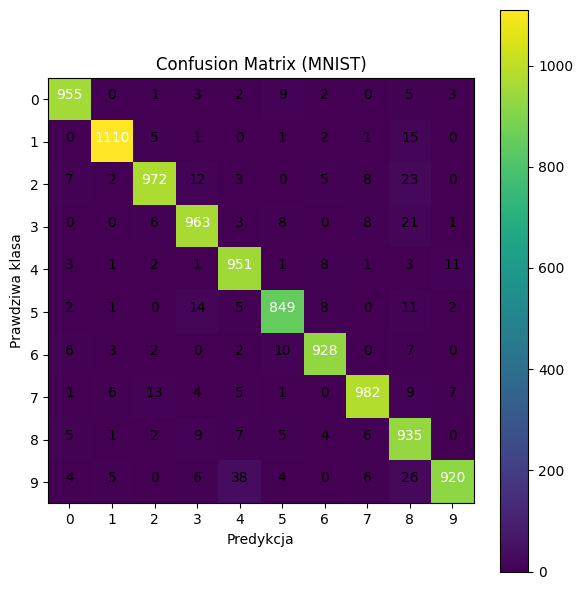

              precision    recall  f1-score   support

           0     0.9715    0.9745    0.9730       980
           1     0.9832    0.9780    0.9806      1135
           2     0.9691    0.9419    0.9553      1032
           3     0.9506    0.9535    0.9521      1010
           4     0.9360    0.9684    0.9520       982
           5     0.9561    0.9518    0.9539       892
           6     0.9697    0.9687    0.9692       958
           7     0.9704    0.9553    0.9627      1028
           8     0.8863    0.9600    0.9216       974
           9     0.9746    0.9118    0.9421      1009

    accuracy                         0.9565     10000
   macro avg     0.9567    0.9564    0.9562     10000
weighted avg     0.9573    0.9565    0.9566     10000



In [22]:
results(model_baseline,test_loader)

Model Baseline poradził sobie przyzwoicie.  
Najgorzej sobie radził z poprawnymi predykcjami dla liczby 4. Posiada dla tej liczby najmniejszą prezycje.  
Najwięcej razy mylił ją z liczbą 9, co ma sens, ponieważ liczba 4 jest taką "kanciastą 9".  
W drugą stronę model pomylił się nawet 38 razy.  

Macierz pomyłek i metryki dla modelu konwolucyjnej sieci neuronowej

e:\Laby\.venv\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9911


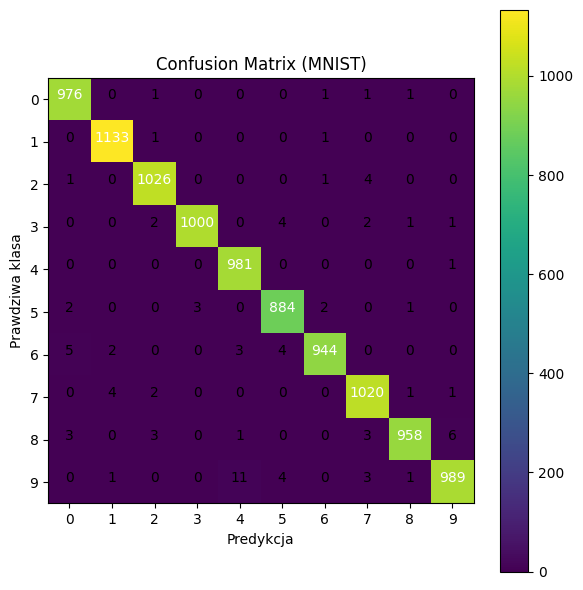

              precision    recall  f1-score   support

           0     0.9889    0.9959    0.9924       980
           1     0.9939    0.9982    0.9960      1135
           2     0.9913    0.9942    0.9927      1032
           3     0.9970    0.9901    0.9935      1010
           4     0.9849    0.9990    0.9919       982
           5     0.9866    0.9910    0.9888       892
           6     0.9947    0.9854    0.9900       958
           7     0.9874    0.9922    0.9898      1028
           8     0.9948    0.9836    0.9892       974
           9     0.9910    0.9802    0.9856      1009

    accuracy                         0.9911     10000
   macro avg     0.9911    0.9910    0.9910     10000
weighted avg     0.9911    0.9911    0.9911     10000



In [17]:
results(model_simple_cnn,test_loader)

Model poradził sobie lepiej niż jego poprzednik.  
Może być to spowodowane tym, że modele konwolucyjne są lepsze w wyłapywaniu wzorców (stosowanie kernela) pomiędzy cechami (pikselami), gdy zwykłe sieci neuronowe każdą cechę traktują osobno.  
Tutaj wcześniejszy problem z myleniem liczb 4 i 9 występuje tylko jednostronnie i w duże mniejszej skali.  



Podsumowanie

Pomimo lekkiego przeuczenia modeli, poradziły sobie całkiem dobrze.  
Konwolucyjna sieć neuronowa znacznie lepiej poradziła sobie w klasyfikacji obrazów niż zwykła sieć neuronowa.  
Co jest zgodne z teorią, ponieważ konwolucyjna sieć korzystając z kernela znajduje lokalne wzorce, a zwykła siec neuronowa traktuje obraz tylko jako wektor pikseli.  

Brakuje tutaj bawienia się parametrami dla ograniczenia overfittingu lub zwiększenia dokładnośći, niestety nie miałem czasu.  

